In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from os import path, listdir
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import cv2
from albumentations import Compose, Normalize, VerticalFlip, HorizontalFlip
from albumentations import Rotate, Resize, LongestMaxSize, PadIfNeeded, BboxParams
from albumentations.pytorch import ToTensor
from torchvision import transforms

from Pytorch.utils import Normalize_bbox_to_0_1, Convert_bbox_from_TLWH_to_TLBR
from Pytorch.utils import clamp, Bbox_clamp
from Pytorch.utils import Show_figure_with_bbox, Denormalize_tensor

In [3]:
training_classes = [0, 1, 7, 10, 13, 15, 17, 18, 19, 20, 26, 30]
test_classes = [2, 3, 6, 11, 12, 21, 22, 31, 16, 36]

In [4]:
exp_name = "Benedettini-FewShotClassification-RN50-IMSize256-FS256-SGD"
epochs = 120
batch_size = 7
output_features = 256
num_batch_train = 200
num_batch_val = 80
IMSize = 256
training_support_set_size = len(training_classes)
test_support_set_size = len(test_classes)

In [5]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [6]:
support_dataset_path = "../../../Datasets/Object Retrieval/Monastero dei Benedettini"
support_dir = path.join(support_dataset_path, 'Training')

In [7]:
from numpy import genfromtxt
def createSupportDict(support_dir, labels_dir):
    labels = genfromtxt(path.join(labels_dir, 'labels.txt'), delimiter='\t').tolist()
    labels = labels[1:] # drop field names
    labels = [[str(label[0]), int(label[1])] for label in labels]
    labels[-2] = ['8.10', labels[-2][1]]
    labels_dict = {int(a) : b for b, a in labels}

    support_dict = {}
    for key, value in labels_dict.items():
        support_dict[key] = [filename for filename in listdir(support_dir) if filename.startswith(str(value)+"_")][0]
    return support_dict

In [8]:
support_dict = createSupportDict(support_dir, support_dataset_path)

In [9]:
support_dict

{0: '5.1_Porta Aula Santo Mazzarino.jpg',
 1: "5.2_Porta d'ingresso al Museo della Fabbrica dei Benedettini.jpg",
 2: '5.3_Porta Antirefettorio.jpg',
 3: "5.4_Porta d'ingresso al Refettorio Piccolo.jpg",
 4: "5.5_Cupola dell'Antirefettorio.jpg",
 5: '5.6_Apertura pavimento.jpg',
 6: '5.7_Scultura S. Agata.jpg',
 7: '5.8_Scultura S. Scolastica.jpg',
 8: '6.1_Quadro Santo Mazzarino.jpg',
 9: '6.2_Affresco Il Trionfo di Benedetto.jpg',
 10: '6.3_Pavimento originale.jpg',
 11: '6.4_Pavimento restaurato.jpg',
 12: '6.5_Bassorilievi mancanti.jpg',
 13: '6.6_Lavamani sinistro.jpg',
 14: '6.7_Lavamani destro.jpg',
 15: '6.8_Tavolo dei Relatori.jpg',
 16: '6.9_Poltrone.jpg',
 17: '7.1_Edicola.jpg',
 18: '7.2_Pavimento A.jpg',
 19: '7.3_Pavimento B.jpg',
 20: '7.4_Passavivande con pavimento originale.jpg',
 21: '7.5_Aperture pavimento.jpg',
 22: '7.6_Scala.jpg',
 23: '7.7_Sala meteorologica.jpg',
 24: '8.1_Doccione.jpg',
 25: '8.2_Vano raccolta cenere.jpg',
 26: '8.3_Sala Rossa.jpg',
 27: '8.4_S

In [10]:
i = 34
while i>7:
    support_dict[i+2] = support_dict[i]
    i = i-1

In [11]:
from collections import OrderedDict
support_dict = OrderedDict(sorted(support_dict.items()))

In [12]:
support_dict[1]

"5.2_Porta d'ingresso al Museo della Fabbrica dei Benedettini.jpg"

In [13]:
'''
CODING CONVENTIONS

- All names use underscore casing
- L_* for list variable names
- D_* for dictionary variable names
- T_* for tensor variable names
- M_* for Pytorch models
- DL_* for Data Loader
- DSET_* for Dataset
- Class names are in upper case
- Function names start with a capital letter
'''

class ZERO_SHOT_DATASET(Dataset):
    def __init__(self,
        root_dirpath,
        images_dirpath,
        annotations_path,
        L_classes_idx_filter,
        support_set_size=10,
        image_id_key="image_id",
        category_id_key="category_id",
        F_image_id_to_relative_path=None,
        augmentation=True,
        desired_size=256,
        batch_size=2,
        num_batch=1):
        
        self.root_dirpath = root_dirpath
        self.images_dirpath = images_dirpath
        self.annotations_path = annotations_path
        self.image_id_key=image_id_key
        self.category_id_key=category_id_key
        self.L_classes_idx_filter = L_classes_idx_filter
        self.support_set_size = support_set_size
        self.F_image_id_to_relative_path = F_image_id_to_relative_path
        self.augmentation = augmentation
        self.desired_size = desired_size
        self.batch_size = batch_size
        self.num_batch = num_batch

        with open(self.annotations_path) as f:
            self.D_instances = json.load(f)
            self.L_annotations = self.D_instances['annotations']
            self.L_categories = self.D_instances['categories']

        # list of real class indices in COCO dataset
        self.L_real_class_idx = [x['id'] for x in self.L_categories]
        # zero-based class indices of COCO dataset (0-79)
        self.L_class_idx = range(len(self.L_real_class_idx))
        # dict to map real class indices to zero-based indices
        self.D_real_class_idx_to_class_idx = { real_class_idx : class_idx for class_idx, real_class_idx in enumerate(self.L_real_class_idx)}

        # dict to map zero based indices to the relative annotations
        self.D_class_to_annotations = self.Create_class_to_annotations_dict()

        # filter zero-based class indices which have no annotations
        self.L_not_empty_class_idx = [class_idx for class_idx in self.L_class_idx if len(self.D_class_to_annotations[class_idx])>0]
        # filter only specified class indices
        self.L_filtered_class_idx = [class_idx for class_idx in self.L_not_empty_class_idx if class_idx in self.L_classes_idx_filter]
        
        augmentation_transform = Compose(
            [
                VerticalFlip(p=0.5),
                HorizontalFlip(p=0.5),
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ]
        )

        loading_transform = Compose(
            [
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ]
        )

        self.transform = augmentation_transform if self.augmentation else loading_transform

    def Create_class_to_annotations_dict(self):
        '''
        Create a dictionary of type (int : list) which map to each zero-based class index a list of
        all the COCO annotations of a specific class using self.D_real_class_idx_to_class_idx as map
        '''
        # init empty dictionary with zero-based class indices
        D_class_to_annotations = {idx : [] for idx in self.L_class_idx}

        for annotation in self.L_annotations:
            real_class_idx = annotation[self.category_id_key]
            class_idx = self.D_real_class_idx_to_class_idx[real_class_idx]
            D_class_to_annotations[class_idx].append(annotation)

        return D_class_to_annotations

    def Get_num_classes(self):
        return len(self.L_categories)

    def Get_class_idx_description(self, class_idx):
        return self.L_categories[class_idx]
    
    def Get_support_image_from_class(self, class_idx):
        item_PIL_image = Image.open(path.join(support_dir, support_dict[class_idx])).convert('RGB')
        D_item_transformed = self.transform(image = np.array(item_PIL_image))
        return D_item_transformed['image']
    
    def Get_random_image_from_class(self, class_idx):
        try:
            D_item_annotation = np.random.choice(self.D_class_to_annotations[class_idx])
            item_image_id = D_item_annotation[self.image_id_key]
            if(self.F_image_id_to_relative_path):
                image_relative_path = self.F_image_id_to_relative_path(item_image_id)
            else:
                image_relative_path = item_image_id
            item_PIL_image = Image.open(path.join(self.images_dirpath, image_relative_path)).convert('RGB')
            image_width, image_height = item_PIL_image.size

            item_bbox = Bbox_clamp(D_item_annotation['bbox'], image_width, image_height)
            item_PIL_image_patch = item_PIL_image.crop((item_bbox[0], item_bbox[1], item_bbox[0]+item_bbox[2], item_bbox[1]+item_bbox[3]))
            D_item_transformed = self.transform(image = np.array(item_PIL_image_patch))
            return D_item_transformed['image']
        except:
            return self.Get_random_image_from_class(class_idx)

    def __getitem__(self, index):

        T_batch_images = torch.Tensor(self.batch_size, self.support_set_size+1, 3, self.desired_size, self.desired_size)
        T_batch_gt = torch.LongTensor(self.batch_size, )
        
        for batch_index in range(self.batch_size):
            L_support_idx = np.random.choice(self.L_filtered_class_idx, size=self.support_set_size, replace=False)
            np.random.shuffle(L_support_idx)
            L_target_idx = np.random.choice(len(L_support_idx))
            target_class_idx = L_support_idx[L_target_idx]
            L_support_and_target_idx = np.append(L_support_idx, target_class_idx)
            for internal_index in range(self.support_set_size):
                T_image = self.Get_random_image_from_class(L_support_and_target_idx[internal_index])
                T_batch_images[batch_index, internal_index] = T_image
                
            T_batch_images[batch_index, self.support_set_size] = self.Get_random_image_from_class(L_support_and_target_idx[self.support_set_size])
            T_batch_gt[batch_index] = L_target_idx

        return (T_batch_images,), T_batch_gt

    def __len__(self):
        return self.num_batch#*self.batch_size

In [14]:
DSET_training = ZERO_SHOT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/train_dataset.json',
    L_classes_idx_filter = training_classes,
    support_set_size=training_support_set_size,
    image_id_key="path",
    category_id_key="class_id",
    augmentation = True,
    batch_size = batch_size,
    num_batch = num_batch_train,
    desired_size = IMSize
)

In [15]:
DSET_validation = ZERO_SHOT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/val_dataset.json',
    L_classes_idx_filter = test_classes,
    support_set_size=test_support_set_size,
    image_id_key="path",
    category_id_key="class_id",
    augmentation = False,
    batch_size = batch_size,
    num_batch = num_batch_val,
    desired_size = IMSize
)

In [16]:
DL_training = DataLoader(DSET_training, batch_size=1, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=1, shuffle=False)

In [17]:
train_batch_example = DSET_training[0]
test_batch_example = DSET_validation[0]

In [18]:
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [19]:
import matplotlib.pyplot as plt
def show_item(sample, n_rows=5, n_cols=5):
    fig = plt.figure(figsize=(40, 40))
    fig.patch.set_alpha(0.5)
    gs = fig.add_gridspec(n_rows+1, n_cols)
        
    r = 1
    c = 0

    for idx, img in enumerate(sample):
        ax = fig.add_subplot(gs[r, c])
        c+=1
        if c == n_cols:
            c=0
            r+=1
        img = denormalize_func(img)
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
        ax.title.set_text(idx)
    plt.show()

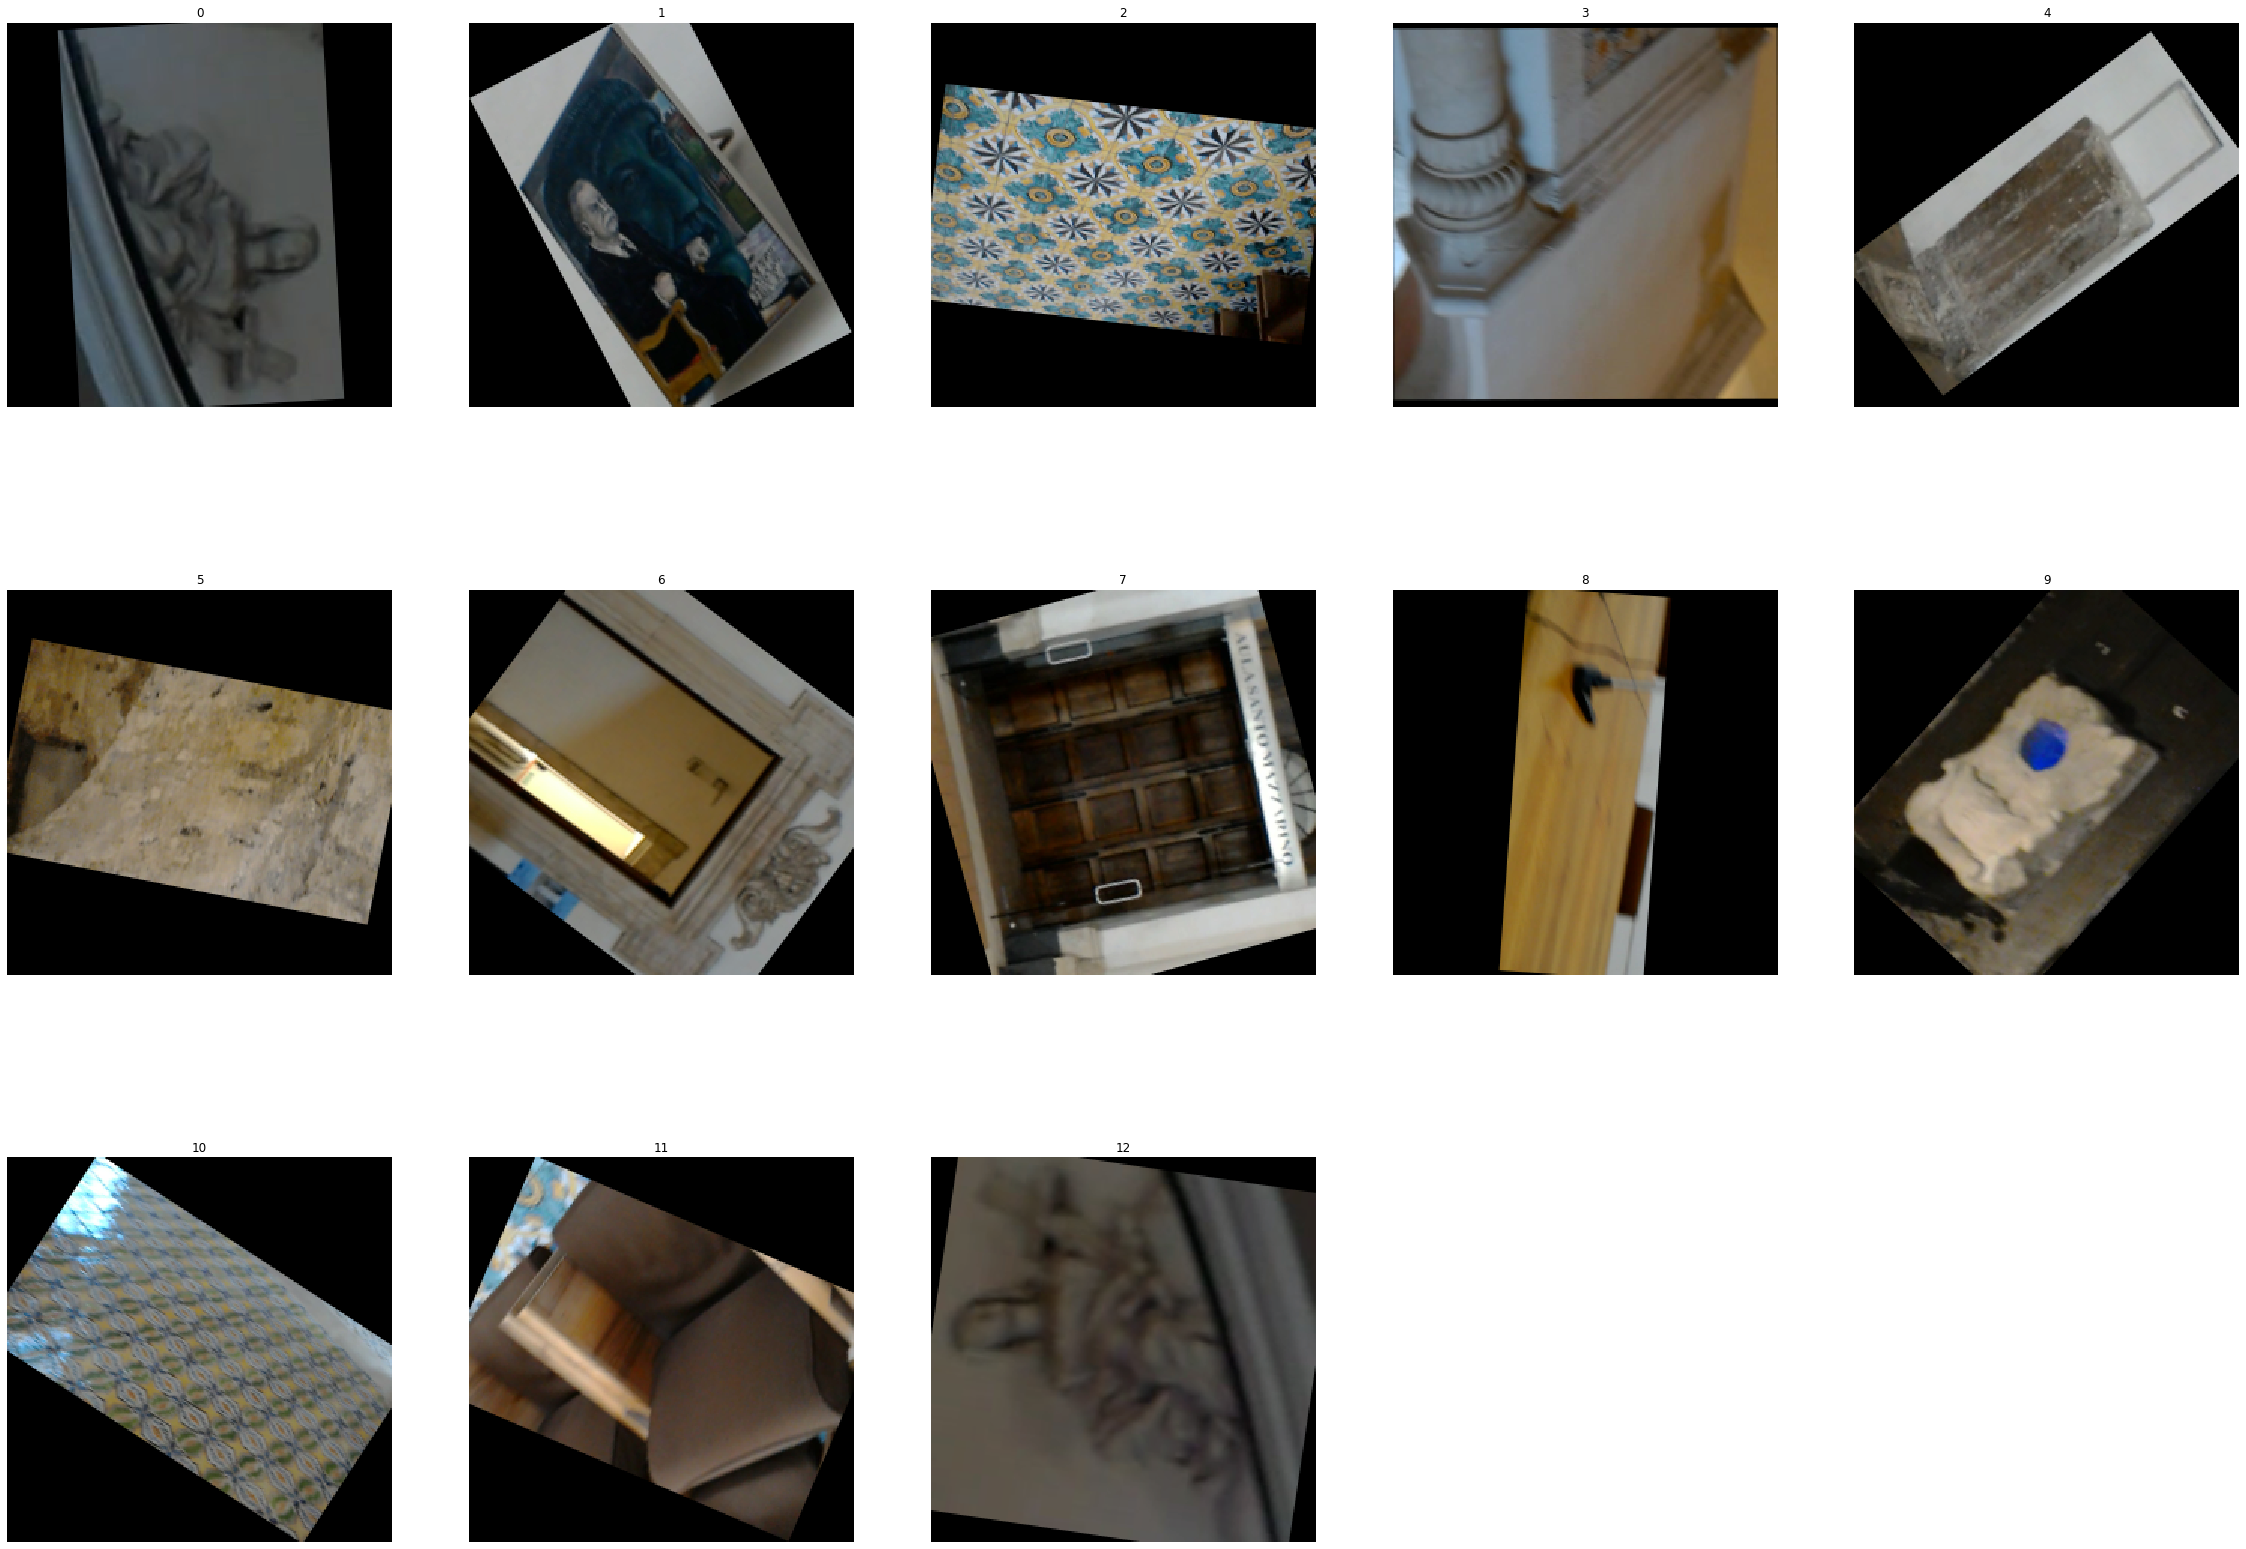

tensor(0)


In [20]:
(T_batch_images,), T_batch_gt = train_batch_example
show_item(T_batch_images[0], n_rows=3, n_cols=5)
print(T_batch_gt[0])

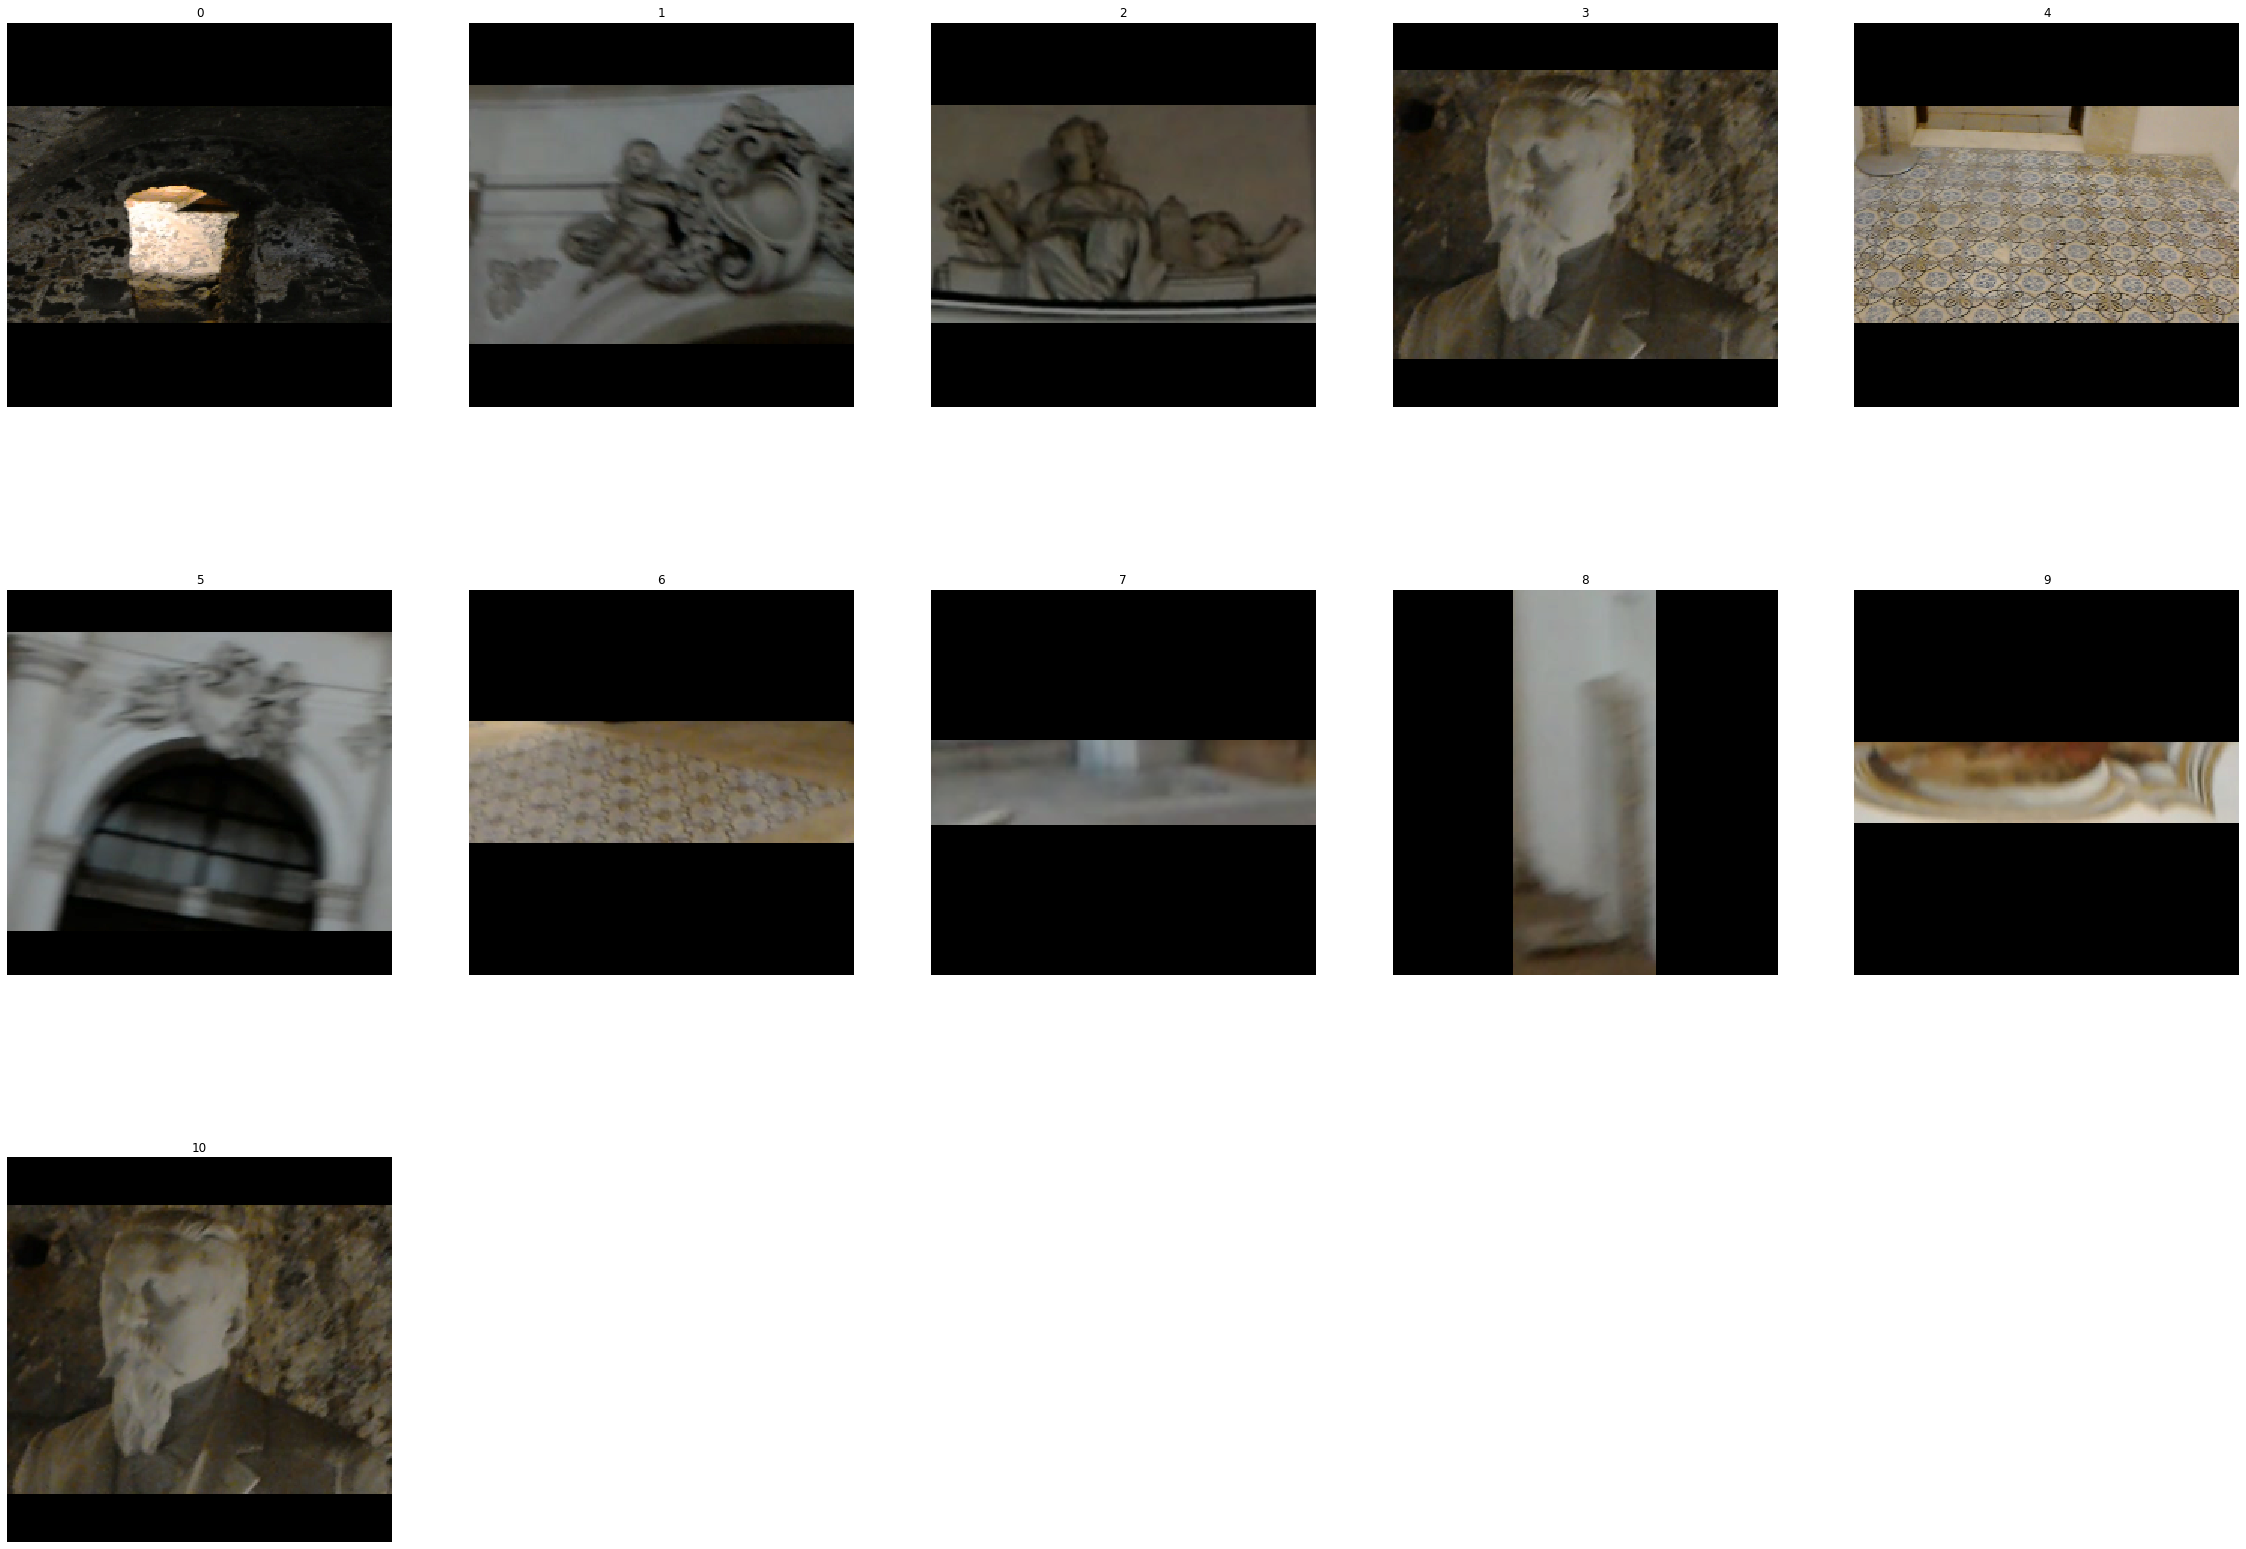

tensor(3)


In [21]:
(T_batch_images,), T_batch_gt = test_batch_example
show_item(T_batch_images[0], n_rows=3, n_cols=5)
print(T_batch_gt[0])

In [22]:
import torch
from torchvision.models import resnet50
from torchvision.ops import RoIPool
from torchvision.ops import RoIAlign

class M_FEATURES_EXTRACTOR(torch.nn.Module):
    def __init__(self, features_size, backbone=None):
        super(M_FEATURES_EXTRACTOR, self).__init__()

        self.features_size = features_size
        self.M_backbone = backbone
        if self.M_backbone is None:
            self.M_backbone = resnet50(pretrained=True)

        self.M_backbone.fc = torch.nn.Linear(
            in_features = self.M_backbone.fc.in_features, 
            out_features = self.features_size,
            bias=True
        )
        
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, T_batch_images):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        T_extracted_features = self.M_backbone(T_batch_images)
        return self.relu(T_extracted_features)

In [23]:
import os
import numpy as np
import torch
from torch.nn import Module, Linear

class ProtoNet(Module):

    def __init__(self):
        super(ProtoNet, self).__init__()
        self.features = output_features
        self.features_extractor = M_FEATURES_EXTRACTOR(self.features)

    def forward(self, batch):
        (T_batch_images,) = batch
        batch_size = T_batch_images.shape[0]
        support_size = T_batch_images.shape[1] - 1
        T_batch_embeddings = torch.Tensor(batch_size, support_size+1, self.features).to("cuda")
        for internal_index in range(support_size+1):
            T_batch_embeddings[:, internal_index] = self.features_extractor(T_batch_images[:, internal_index])
    
        T_supports_embeddings = T_batch_embeddings[:, :support_size] # [batch_size, support_size, features]
        T_targets_embeddings = T_batch_embeddings[:, support_size:] # [batch_size, 1, features]
        distances = (T_supports_embeddings - T_targets_embeddings).pow(2).sum(dim=2).sqrt()
        return (-distances).softmax(dim=1)

In [24]:
M_proto = ProtoNet().to("cuda")

In [25]:
def prepare_batch_fn(batch, gt):
    #remove batch dimension added by the data loader for both batch and gt
    #this is due to the fact that we create batch inside the dataset
    batch = (batch[0][0],)
    gt = gt[0].long()
    return batch, gt

In [26]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculateaccuracycallback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculatelosscallback import CalculateLossCallback
from torchtrainer.callbacks.plotcallback import PlotCallback
from torchtrainer.callbacks.saveparameterscallback import SaveParametersCallback
from torchtrainer.callbacks.settqdmbardescription import SetTQDMBarDescription
from torchtrainer.callbacks.lrbatchschedulercallback import LRBatchSchedulerCallBack

In [27]:
optimizer = torch.optim.SGD(M_proto.parameters(), lr = 0.01, momentum = 0.0)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_proto,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 0,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        SetTQDMBarDescription(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [ ]:
trainer.start()

Epoch 0


Loss = 2.3587 Top-1 accuracy = 50.1910 :  94%|█████████▎| 187/200 [14:44<01:01,  4.72s/it]